In [1]:
%load_ext autoreload
%autoreload 2
import energyderivatives as ed

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [25]:
S = 100
K = 100
t = 1 / 12
sigma = 0.4
r = 0.10
b = 0.1

path_length = 30
mc_paths = 5000
mc_loops = 50

## Full Example from Scratch

In [47]:
import energyderivatives as ed
from scipy.stats import qmc, norm
import numpy as np
from energyderivatives.monte_carlo_options import Innovations, Path, Payoff
S = 100
K = 100
t = 1 / 12
sigma = 0.4
r = 0.10
b = 0.1
path_length = 30
mc_paths = 5000
mc_loops = 50

class NormalSobolInnovations(Innovations):
    def sample_innovation(self, scramble=True):
        sobol = qmc.Sobol(self.path_length, scramble=scramble).random(self.mc_paths)
        if scramble == False:
            # add new sample since if not scrambled first row is zero which leads to -inf when normalized
            sobol = sobol[1:]
            sobol = np.append(
                sobol,
                qmc.Sobol(self.path_length, scramble=scramble).fast_forward(self.mc_paths).random(1),
                axis=0,
            )
        sobol = norm.ppf(sobol)
        return sobol

class WienerPath(Path):
    def generate_path(self, **kwargs):
        return (self.b - (self.sigma ** 2) / 2) * self.dt + self.sigma * np.sqrt(self.dt)  * self.epsilon

class PlainVanillaPayoff(Payoff):
    def call(self):
        St = self.S * np.exp(np.sum(self.path.generate_path(), axis=1))
        return np.exp(-self.r * self.t) * np.maximum(St - self.K, 0)

    def put(self):
        St = self.S * np.exp(np.sum(self.path.generate_path(), axis=1))
        return np.exp(-self.r * self.t) * np.maximum(self.K - St, 0)

mc = ed.monte_carlo_options.MonteCarloOption(
        mc_loops, path_length, mc_paths,
        S, K, t, r, b, sigma,
        NormalSobolInnovations, WienerPath, PlainVanillaPayoff,
        trace=False, antithetic=True, standardization=False
    )


In [48]:
mc.call().mean()


/home/bcho/miniconda3/envs/main/lib/python3.9/site-packages/scipy/stats/_qmc.py:1078: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


5.008738009743555

In [49]:
y = mc.call()

/home/bcho/miniconda3/envs/main/lib/python3.9/site-packages/scipy/stats/_qmc.py:1078: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


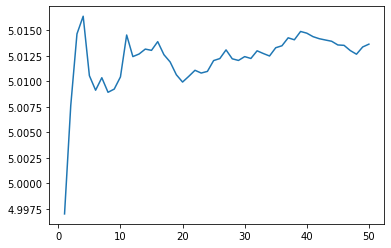

In [50]:
plt.plot(np.arange(y.size)+1, y.cumsum()/(np.arange(y.size)+1))

In [51]:
mc.put().mean()

/home/bcho/miniconda3/envs/main/lib/python3.9/site-packages/scipy/stats/_qmc.py:1078: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


4.186245150048735

## Simplified Example Using Prebuilt Classes

In [54]:
opt = ed.GBSOption(S, K, t, r, b, sigma)

In [55]:
inno = ed.monte_carlo_options.NormalSobolInnovations
path = ed.monte_carlo_options.WienerPath
payoff = ed.monte_carlo_options.PlainVanillaPayoff

In [56]:
mc = ed.monte_carlo_options.MonteCarloOption(
    mc_loops, path_length, mc_paths, 
    S, K, t, r, b, sigma,
    inno, path, payoff,
    trace=False, antithetic=True, standardization=False
)


In [57]:

print("MC: ", mc.call().mean(), "GBS: ", opt.call())





MC:  5.014035874310879 GBS:  5.011784286195763


In [58]:

print("MC: ", mc.put().mean(), "GBS: ", opt.put())



/home/bcho/miniconda3/envs/main/lib/python3.9/site-packages/scipy/stats/_qmc.py:1078: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"




MC:  4.186056958427769 GBS:  4.181913550083365
